# Cell tracking 

Two important processes in normal tissue development and disease are cell migration and proliferation. To gain a better understanding on these processes, tracking in time-lapse datasets is needed. 

Tracking is the motion-analysis of individual objects over space and time. Hereby a unique number for each detected object is generated and maintained.

See also
- [Automated deep lineage tree analysis using a Bayesian single cell tracking approach](https://www.youtube.com/watch?v=JZ6QUZIds2g)
- [btrack user guide](https://btrack.readthedocs.io/en/latest/user_guide/simple_example.html)
- [Single cell tracking with napari](https://napari.org/stable/tutorials/tracking/cell_tracking.html)
- [btrack example notebooks](https://github.com/quantumjot/btrack/blob/main/examples/example_tracking_pipeline-features.ipynb)

To find out more about tracking, we will explore a cancer cell migration dataset from [Tinevez, J. & Guillaume Jacquemet, G.](https://zenodo.org/record/5206107#.ZFthHnZBxPa) licensed by [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode). We will concentrate on a [cropped](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/12_image_analysis_basics/04_Cropping_images.html) region of the dataset (in `x`, `y` and `t`).

In [1]:
import btrack
from skimage.io import imread, imsave
import napari
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from napari_skimage_regionprops import add_table

## Image dimensionality

First, we need to read in our segmentation result as it is the base of the tracking. Let's also read in the image itself, to be able to see both even though it's not needed for the tracking itself (only for measuring intensity values).

In [2]:
image = imread('../../data/cancer_cell_migration_crop.tif')
label_image = imread('../../data/cancer_cell_migration_voronoi_otsu_labeling_crop.tif')

We can check our image `shape` 

In [3]:
label_image.shape

(48, 130, 130)

And see it is sorted with the dimensions `[t,y,x]` with
- `t` = time
- `y` = number of pixels in y
- `x` = number of pixels in x

## Visualization of image and label image

We can use [`stackview`](https://github.com/haesleinhuepf/stackview) to visualize this 4D stack.

In [4]:
import stackview

`stackview.curtain` allows us to visualize our label_image on top of our image

In [5]:
stackview.curtain(image, label_image, continuous_update=True,zoom_factor = 3) 

## Feature extraction

We can connect the label image to features we want to measure. These features are based on [scikit-image regionprops](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops).

In [6]:
# choosing features of interest
features = ['area', 'mean_intensity']

In [7]:
# connect labels to features (if you want to measure intensity-based features, also provide the image)
objects = btrack.utils.segmentation_to_objects(label_image, image, features)

[INFO][2023/05/25 03:32:40 PM] Localizing objects from segmentation...
[INFO][2023/05/25 03:32:41 PM] Found intensity_image data
[INFO][2023/05/25 03:32:41 PM] Calculating weighted centroids using intensity_image
[INFO][2023/05/25 03:32:41 PM] Objects are of type: <class 'dict'>
[INFO][2023/05/25 03:32:41 PM] ...Found 650 objects in 48 frames.


## Tracking using btrack

To configure the tracker, we need a configuration file. We will take here a preconfigured model instead of configuring one ourselves:

In [8]:
from btrack import datasets

In [9]:
config_file = datasets.cell_config()

In [10]:
config_file

'C:\\Users\\maral\\AppData\\Local\\btrack-examples\\btrack-examples\\Cache\\examples\\cell_config.json'

In [11]:
# initialise a tracker session 
with btrack.BayesianTracker() as tracker:

  # configure the tracker using a preconfigured config file
  tracker.configure(config_file)

  # append the objects to be tracked
  tracker.append(objects)
    
  # set the volume
  tracker.volume = ((0, 130), (0, 130)) # if the dataset has multiple z-dimensions, we need an additional bracket

  # track
  tracker.track_interactive(step_size=100)

  # get the tracks in a format for napari visualization
  data, properties, graph = tracker.to_napari(ndim=2)

[INFO][2023/05/25 03:32:41 PM] Loaded btrack: C:\Users\maral\mambaforge\envs\laptrack_env2\lib\site-packages\btrack\libs\libtracker.DLL
[INFO][2023/05/25 03:32:41 PM] Starting BayesianTracker session
[INFO][2023/05/25 03:32:41 PM] Loading configuration file: C:\Users\maral\AppData\Local\btrack-examples\btrack-examples\Cache\examples\cell_config.json
[INFO][2023/05/25 03:32:41 PM] Objects are of type: <class 'list'>
[WARNING][2023/05/25 03:32:41 PM] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2023/05/25 03:32:41 PM] Starting tracking... 
[INFO][2023/05/25 03:32:41 PM] Update using: ['MOTION']
[INFO][2023/05/25 03:32:41 PM] Tracking objects in frames 0 to 48 (of 48)...
[INFO][2023/05/25 03:32:41 PM]  - Timing (Bayesian updates: 1.00ms, Linking: 0.00ms)
[INFO][2023/05/25 03:32:41 PM]  - Probabilities (Link: 0.99998, Lost: 0.46180)
[INFO][2023/05/25 03:32:41 PM] SUCCESS.
[INFO][2023/05/25 03:32:41 PM]  - Found 29 tracks in 48 frames (in 0.0s)
[INFO][2023/05/25 03:32

## Visualizing the output in napari

Next, we visualize the result in napari.

In [12]:
# open a napari-viewer
viewer = napari.Viewer()

In [13]:
# add a labels layer and connect it to the features of interest
labels_layer = viewer.add_labels(label_image, features = properties)

In [14]:
# add a tracks layer
tracks_layer = viewer.add_tracks(data)

In [15]:
# add the features as a table to napari
add_table(labels_layer, viewer)

Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342


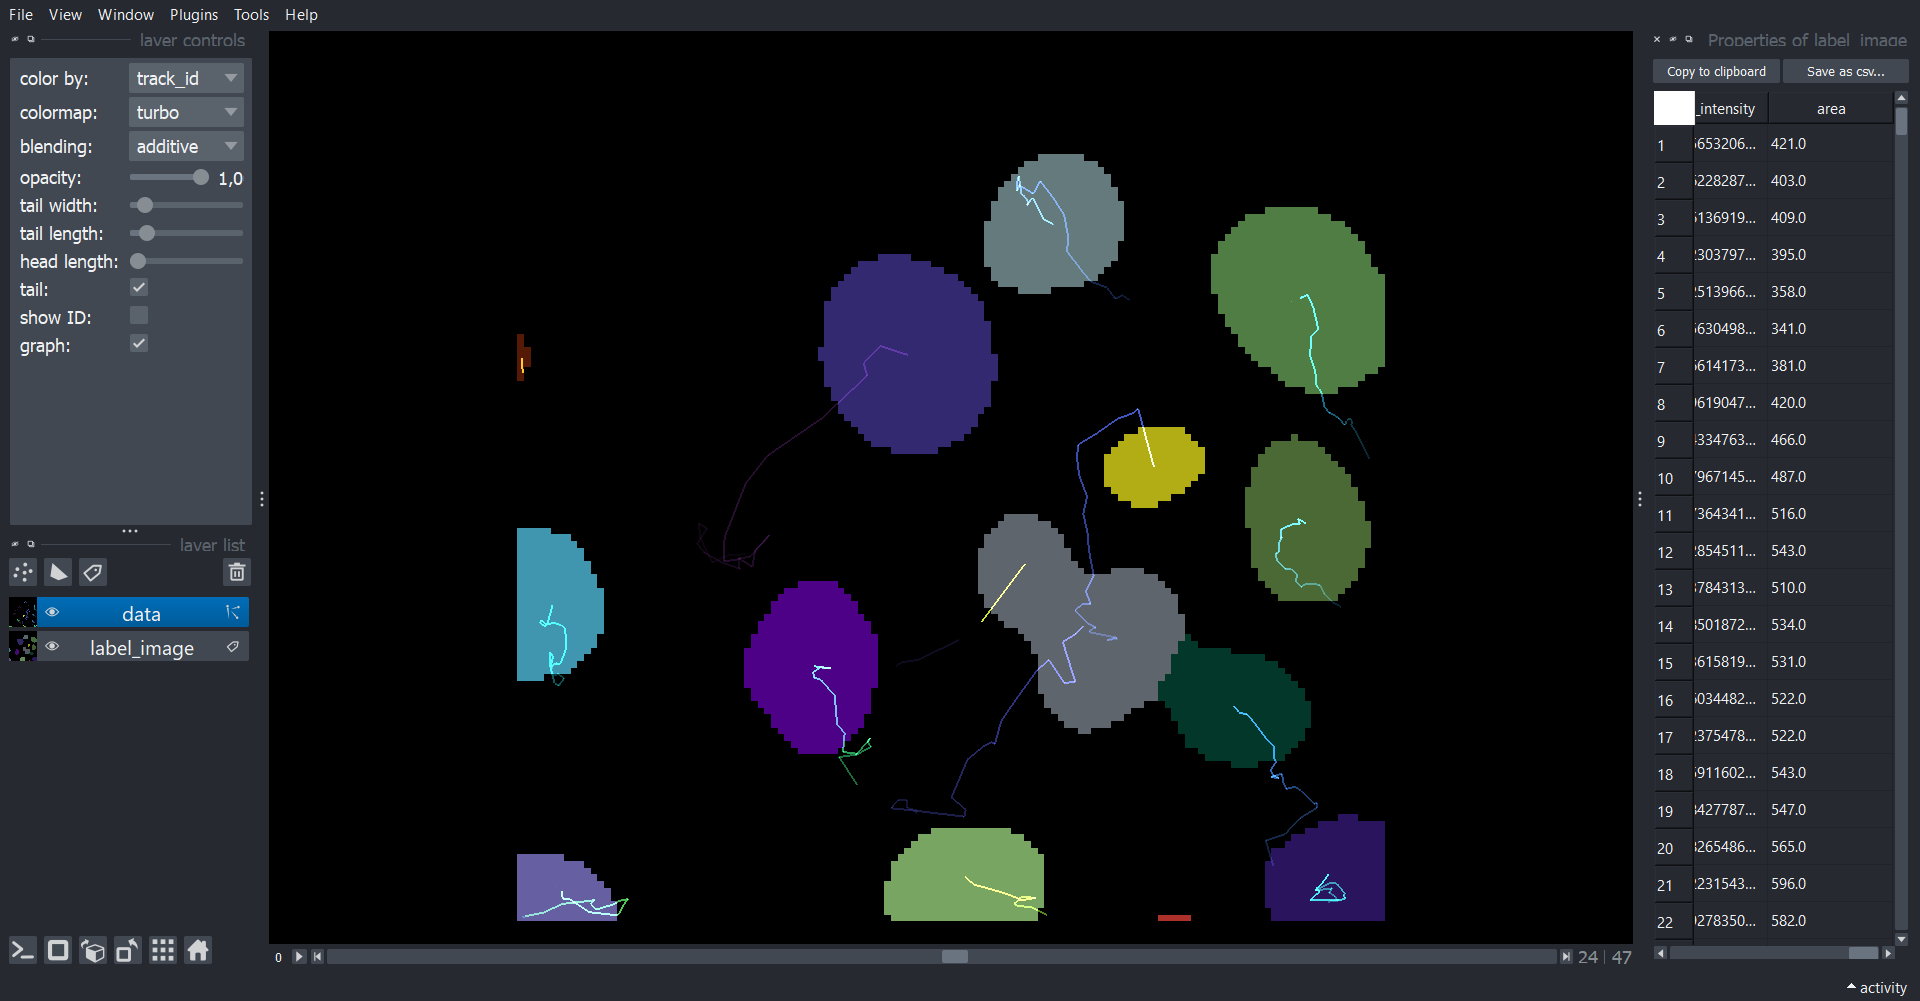

In [17]:
napari.utils.nbscreenshot(viewer)